# **Modeling Non-Stationary Time Series**
Author: Moamen Abdelkawy

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import wbgapi as wb
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed
np.random.seed(37)


In [2]:
# UDFs

def adf_tests(df, lags=None, trend='trend', method='method', indicator=None):
    """
    Perform Augmented Dickey-Fuller (ADF) tests on each column of a DataFrame.

    This function takes a DataFrame as input and performs the ADF test on each column.
    The ADF test is used to determine if a time series is stationary or not.
    The test is applied to each column of the DataFrame and the results are printed.

    Parameters:
    - df (DataFrame): The input DataFrame containing the time series data.
    - lags (int or None): The number of lags to include in the test. If None, a default value is used.
    - trend (str): The trend component to include in the test. Default is 'trend'.
    - method (str): The method used to estimate the test statistic. Default is 'method'.
    - indicator (str or None): An optional indicator to include in the test results. Default is None.

    Returns:
    None

    Raises:
    None
    """

    # Iterate over each column in the DataFrame
    for i, c in enumerate(df.columns):
        # Perform ADF test on the current column
        c_adf = ADF(df[c], trend=trend, method=method)

        # Print the test results with the column name and indicator
        print('{} {} Augmented Dickey-Fuller Test'.format(c, indicator))
        print('Test statistics and critical values: \n', c_adf)

        # Add a separator between test results if not the last column
        if i < len(df.columns) - 1:
            print('\n', "# " * 50, '\n')
        else:
            break

def calculate_vif(X_df):
    """
    Calculate the Variance Inflation Factor (VIF) for each variable in a DataFrame.

    Parameters:
    - X_df (DataFrame): The DataFrame containing the independent variables.

    Returns:
    DataFrame: A DataFrame with two columns: "Variable" and "VIF".
              The "Variable" column contains the names of the variables,
              and the "VIF" column contains the corresponding VIF values.
    """
    # Add a constant column to the DataFrame
    X_const = add_constant(X_df)

    # Create an empty DataFrame to store the VIF values
    vif_data = pd.DataFrame()

    # Calculate the VIF for each variable (skip the constant column)
    vif_data["Variable"] = X_const.columns[1:]
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(1, X_const.shape[1])]

    return vif_data

def reduce_multicollinearity(X_df, threshold=10):
    """
    Reduce multicollinearity in a DataFrame by iteratively removing variables with high VIF scores.

    Parameters:
    - X_df (DataFrame): The DataFrame containing the independent variables.
    - threshold (float): The threshold above which a VIF score is considered high.

    Returns:
    DataFrame: The DataFrame with reduced multicollinearity.
    """
    while True:
        # Calculate the VIF for the current DataFrame
        vif_data = calculate_vif(X_df)
        max_vif = vif_data["VIF"].max()

        if max_vif > threshold:
            # Identify the variable with the highest VIF
            max_vif_var = vif_data.loc[vif_data["VIF"] == max_vif, "Variable"].iloc[0]

            # Drop the variable from the DataFrame
            X_df = X_df.drop(columns=[max_vif_var])
            print(f"Removed {max_vif_var} with VIF of {max_vif}")
        else:
            break

    return X_df


## **Definitions**

In a non-stationary time series, the statistical properties, such as mean, variance, and autocorrelation can change over time. Most economic data series are not stationary, as they don't have constant averages and display 
phases of relative stability followed by periods of high variability [[1]](http://annals.feaa.usv.ro/index.php/annals/article/viewArticle/262).

A non-stationary time series $y_t$ can often be stationary by differencing. If the time series becomes stationary after differencing $(d)$ times, $y_t$ is said to be integrated of order $(d)$, denoted $I(d)$ [[2]](https://learn.wqu.edu/my-path/courses/financial-econometrics/modules/m-6-time-series-modeling-iii-cointegration/tasks/lesson-1-unit-root-tests-lesson-notes).

**In General**

> If $y_t \sim I(d)$, then $ (1-B)^d y_t$ is a stationary time series.

The problem with this approach is that when performing multivariate time series analysis, differencing each series can lead to loss of long-term information. If these series have a long-term equilibrium relationship, it will be lost in the process. This case is called cointegration, where the linear combination of non-stationary series is stationary [[3]](https://www.jstor.org/stable/3532929).

**Cointegration Can be Expressed as Follows**

> The non-stationary time series $Y_{1t}, Y_{2t}, \ldots, Y_{nt}$ are cointegrated if there exists a vector $\alpha = (\alpha_1, \alpha_2, \ldots, \alpha_n) $ such that the linear combination $ Z_t = \alpha_1Y_{1t} + \alpha_2Y_{2t} + \ldots + \alpha_nY_{nt} $ is stationary [[4]](https://www.bauer.uh.edu/rsusmel/phd/ec2-7.pdf).

**Vector Error Correction Model (VECM)**

To model multiple cointegrated time series, this report utilizes the **Vector Error Correction Model (VECM)**, which can be expressed as follows [[5]](https://learn.wqu.edu/my-path/courses/financial-econometrics/modules/m-6-time-series-modeling-iii-cointegration/tasks/lesson-4-vector-error-correction-model-and-johansen-test-for-cointegration-lesson-notes)

$$ \Delta X_t = C + \Pi X_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta X_{t-i} + \epsilon_t $$

Here:
- $C$ is a deterministic vector or matrix for constants and/or linear trends,
- $\Pi$ is an $n \times n$ matrix for the coefficients of lagged $X_{t-1}$,
- $\Gamma_i$ represents the $n \times n$ matrices for coefficients of lagged differences of $X$,
- $\epsilon_t$ is an $n \times 1$ white noise vector.

This model can analyze both long-term and short-term dynamics between $I(1)$ cointegrated time series. $\Pi X_{t-1}$ is the long equilibrium part, while the $\sum_{i=1}^{p-1} \Gamma_i \Delta X_{t-i}$ term represents the short-term movements.

Cointegration occurs when the rank of $\Pi$ is between zero and $n$, where $n$ is the total number of time series. This is the main focus of Johansen cointegration test.


## **Dataset Description**

This report analyzes a dataset of 4 time series for macroeconomic indicators of the Egyptian economy between 1977 and 2021: 
- GDP (current US$), denoted as $GDP$
- Exports of goods and services (BoP, current US$), denoted as $EXP$
- General government final consumption expenditure (current US$), denoted as $G$
- Gross fixed capital formation (current US$), denoted as $I$

These four time series represent ***Aggregate Demand*** in Keynesian analysis [[6]](https://www.elgaronline.com/view/journals/roke/1-1/roke.2013.01.01.xml?), after excluding Households consumption. It is expected to have a long-term equilibrium among these series. By their economic nature, these time series are expected to be non-stationary. The reason to exclude households consumption from this analysis is because the model suffered a near-perfect multicollinearity when it was included.

Modeling these 4 time series and finding the long-term equilibrium provides a macroeconomic snapshot of how key components of aggregate demand are related to overall economic output in the long term.

## **Modeling Workflow**

Data is imported into a pandas DataFrame using `wbgapi` library [[7]](https://nbviewer.org/github/tgherzog/wbgapi/blob/master/examples/wbgapi-cookbook.ipynb) to access to the World Bank's data API. After importing, limited wrangling was performed to transpose the DataFrame into a wide format, create an index by year, and rename and sort the columns.

In [3]:
# Importing the data into a pandas DataFrame using WB API
df = wb.data.DataFrame(
    ['NY.GDP.MKTP.CD', 'BX.GSR.GNFS.CD', 'NE.CON.GOVT.CD', 'NE.GDI.FTOT.CD'], 
    economy='EGY', 
    time=range(1977,2021), 
    labels=False)


In [4]:
# Transposing the DataFrame
df = df.T
# Set the index name
df.index.name = 'year'
# Convert index to int
df.index = df.index.str.replace('YR', '').astype(int)


In [5]:
# Renaming columns
rename_dict = {
'NY.GDP.MKTP.CD': 'GDP',
'BX.GSR.GNFS.CD': 'EXP',
'NE.CON.GOVT.CD': 'G',
'NE.GDI.FTOT.CD': 'I'
}

df = df.rename(columns=rename_dict)

# Sort columns alphabetically
df = df.sort_index(axis=1)


In [6]:
# Checking the DataFrame structure and integrity
df.head()


series,EXP,G,GDP,I
year,,,,
1977,3.574705e+09,2.976320e+09,1.440081e+10,3.224522e+09
1978,3.572150e+09,2.790479e+09,1.481170e+10,3.999090e+09
1979,4.211857e+09,2.920143e+09,1.802057e+10,5.295714e+09
1980,6.246286e+09,3.395570e+09,2.166991e+10,5.335708e+09
1981,6.535714e+09,3.838243e+09,2.213608e+10,7.105405e+09


With visual assessment, it seems that all four time series are non-stationary, and have possible co-movements. 

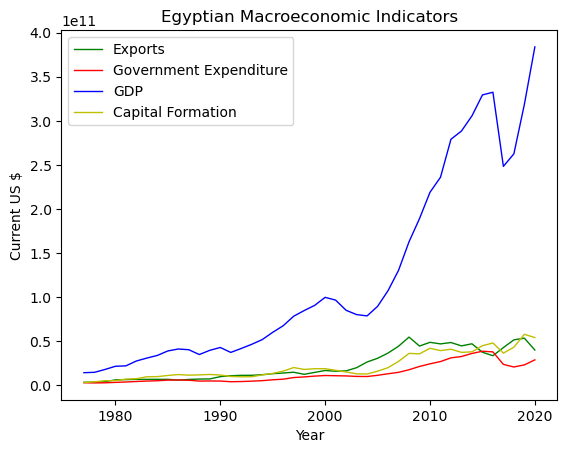

In [7]:
# Plot the original data
plt.plot(df.EXP, linewidth=1, c="g", label="Exports")
plt.plot(df.G, linewidth=1, c="r", label="Government Expenditure")
plt.plot(df.GDP, linewidth=1, c="b", label="GDP")
plt.plot(df.I, linewidth=1, c="y", label="Capital Formation")
plt.title('Egyptian Macroeconomic Indicators')
plt.xlabel('Year')
plt.ylabel('Current US $')
plt.legend()
plt.show()


This report uses **Augmented Dickey Fuller (ADF)** test to examine stationarity for each time series. The code utilizes a custom function `adf_tests` that takes a DataFrame as input and performs the ADF test on each column.

In [8]:
# Checking Stationarity in the original data, no constant or trend
adf_tests(df=df, trend='n', method='bic', indicator = '"EGY"')


EXP "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.400
P-value                         0.801
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.62 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

G "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  2.403
P-value                         0.997
Lags                                8
-------------------------------------

Trend: No Trend
Critical Values: -2.63 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 #

In [9]:
# Checking Stationarity in the original data, constant with no trend
adf_tests(df=df, trend='c', method='bic', indicator = '"EGY"')


EXP "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -0.929
P-value                         0.778
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.59 (1%), -2.93 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

G "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  1.426
P-value                         0.997
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.63 (1%), -2.95 (5%), -2.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 #

In [10]:
# Checking Stationarity in the original data, constant and a linear trend
adf_tests(df=df, trend='ct', method='bic', indicator = '"EGY"')


EXP "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -2.051
P-value                         0.573
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.19 (1%), -3.52 (5%), -3.19 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

G "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -2.873
P-value                         0.171
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.19 (1%), -3.52 (5%), -3.19 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypot

It is clear from ADF tests results that all four time series have a unit root, even when tested under different conditions (no constant or trend - constant without trend - constant and a linear trend).

To determine the order of integration for each time series, each series must be differenced and retested for stationarity. 

In [11]:
# Taking the first difference
df_d = df.diff().dropna()


In [12]:
# Checking Stationarity for the first difference of the original data, no constant or trend
adf_tests(df=df_d, trend='n', method='bic', indicator = '"EGY"')


EXP "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -5.103
P-value                         0.000
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.62 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

G "EGY" Augmented Dickey-Fuller Test
Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -3.791
P-value                         0.000
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.62 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

 #

All four time series reached stationarity after the first difference under the same conditions (no constant or trend), this means that all four time series are $I(1)$. 

Being integrated of the same order is crucial to run the VECM, this has been now confirmed.

The next step is to determine the number of lags in the VECM. This can be done in Python by fitting VAR model from `statsmodels` library, and run the lag selection tool.

In [13]:
# Fit VAR model and run lag selection tool
model = VAR(df)
# maxlags = None allows for maximum number of lags available for the size of the dataset
# Setting the trend to 'n' raises an IndexError
# Due to this error, I decided on setting the trend to 'c' (which is the default value for this method)
x = model.select_order(maxlags=None, trend="c") 
x.summary()


,AIC,BIC,FPE,HQIC
0,184.1,184.3,8.864e+79,184.1
1,175.8,176.7,2.256e+76,176.1
2,175.3,176.8,1.342e+76,175.8
3,174.6,176.9,7.925e+75,175.4
4,172.8,175.8,1.537e+75,173.9
5,172.1,175.7,9.787e+74,173.4
6,171.1,175.5,6.688e+74,172.7
7,169.2*,174.3*,2.693e+74*,171.0*


When running the lag selection tool with `trend='n'`, the code raised an `IndexError`. For this reason, I decided to run the tool with `trend='c'`, which is the default for this method.

All four information criteria unanimously recommend using 7 lags for the VAR model. This number of lags will be used in Johansen trace test below.

In [14]:
# Johansen Trace Test Result

jtest = coint_johansen(df, det_order=0, k_ar_diff=7)

# Print the results
print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2", "rank<=3"]  # Rank is adjusted to match the number of test statistics
)


Eigenvalues of VECM coefficient matrix : [1.         0.94460121 0.6796642  0.06895482]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,1366.180535,44.4929,47.8545,54.6815
rank<=1,147.709098,27.0669,29.7961,35.4628
rank<=2,43.553986,13.4294,15.4943,19.9349
rank<=3,2.572109,2.7055,3.8415,6.6349


Johansen trace test reveals that the rank of $\Pi$ is 3, as we can't reject $H_0$ at rank<=3. This confirms the presence of cointegration among these time series, as the rank of $\Pi$ is greater than zero but less than the number of series.

One thing to note in the results of this test is the very high Eigenvalues. This topic will be revisited in the "Damage" section of this report.

The next step is to run VECM itself, under the same conditions in the Johansen trace test (constant with no trend and 7 lags).

In [15]:
# VECM model
vecm_model = VECM(endog=df, k_ar_diff=7, deterministic="c").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation EXP
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.EXP        -2.1714      0.676     -3.214      0.001      -3.496      -0.847
L1.G          -1.9926      1.028     -1.938      0.053      -4.008       0.022
L1.GDP         0.3969      0.105      3.788      0.000       0.192       0.602
L1.I          -0.7573      0.309     -2.448      0.014      -1.363      -0.151
L2.EXP        -1.7050      0.833     -2.048      0.041      -3.337      -0.073
L2.G           2.2636      0.950      2.383      0.017       0.402       4.125
L2.GDP        -0.3379      0.197     -1.719      0.086      -0.723       0.047
L2.I          -0.0566      0.359     -0.158      0.875      -0.760       0.646
L3.EXP        -1.3207      0.610     -2.166      0.030      -2.516      -0.126
L3.G           3.5517      1.571      2.260     

After fitting the model, the linear combination can be written as follows:

$$ S = 1.0 \times EXP - 0.5589 \times G - 0.1024 \times GDP + 0.2319 \times I $$ 

This equation represents the deviation from the long-term equilibrium of the four time series.

For this model to successfully represent the cointegration between these time series, this linear combination needs to be stationary [[8]](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4218834). The next step is to assess the stationarity of this linear combination visually and using ADF test.

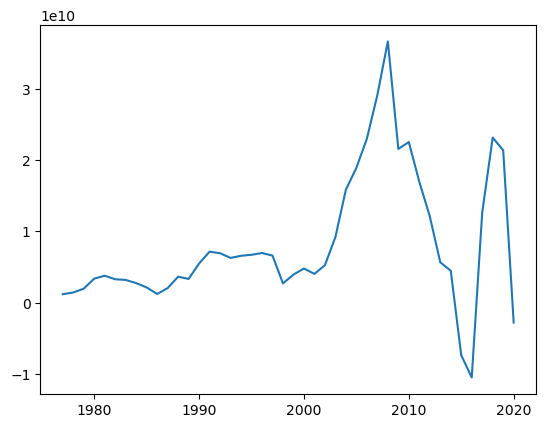

In [16]:
# Time Plot for Deviation from Long-Term Equilibrium
S = (
      vecm_model.beta[0][0] * df.EXP
    + vecm_model.beta[1][0] * df.G
    + vecm_model.beta[2][0] * df.GDP
    + vecm_model.beta[3][0] * df.I
)
plt.plot(S)
plt.show()

In [17]:
# ADF Test Result for Deviation from Long-Term Equilibrium
S_adf = ADF(S, trend="n", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)

Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.071
Model:                            OLS   Adj. R-squared (uncentered):              0.049
Method:                 Least Squares   F-statistic:                              3.213
Date:                Thu, 11 Apr 2024   Prob (F-statistic):                      0.0803
Time:                        22:53:47   Log-Likelihood:                         -1032.2
No. Observations:                  43   AIC:                                      2066.
Df Residuals:                      42   BIC:                                      2068.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-

From the plot and the ADF test results, we can see that the deviation is non-stationary at 5% level (stationary at 10%). Subsequent sections of this report will investigate the reason for that and how to improve the model.

## **Damage**

To understand the problem of the initial model, let's revisit Johansen trace test results:

``` 
Eigenvalues of VECM coefficient matrix : [1.         0.94460121 0.6796642  0.06895482]
```

The first two Eigenvalues are very high, which is concerning. This may indicate econometric problem(s) in the dataset. 

Since multicollinearity is expected in economic data, the report will focus on this issue. The code below us uses a custom function `calculate_vif` that calculates the Variance Inflation Factor (VIF) for each variable in a DataFrame.

In [18]:
# Calculate the VIF for all series
vif_data = calculate_vif(df)

# Print the VIF data
print(vif_data.sort_values("VIF", ascending=False))

  Variable        VIF
2      GDP  51.741809
3        I  29.242368
1        G  18.330877
0      EXP   5.765427


As expected, VIF scores point to considerable multicollinearity in the system. This may explain why the linear combination of the VECM has a unit root.

## **Direction**

Improving the VEC model requires solving the issue of multicollinearity. This can be done in one of two ways: decreasing dimensionality, or using principal component analysis (PCA).

This analysis avoids using PCA as it leads to the loss of interpretability, which is important for this dataset. Solve multicollinearity will thus rely on dimensionality reduction.

The following code uses a custom function `reduce_multicollinearity` that iteratively removes variables with high VIF scores in a DataFrame.

In [19]:
# Remove variables with high VIF
df_reduced = reduce_multicollinearity(df)

Removed GDP with VIF of 51.74180879723641


The result was the removal of `GDP` column. When VIF scores for the reduced dataset are recalculated, solving the issue of multicollinearity is confirmed. 

In [20]:
# Recalculating VIF for the reduced dataset
calculate_vif(df_reduced)

,Variable,VIF
0,EXP,5.264903
1,G,6.292460
2,I,9.498407


In [21]:
# Checking the reduced DataFrame structure and integrity
df_reduced.head()

series,EXP,G,I
year,,,
1977,3.574705e+09,2.976320e+09,3.224522e+09
1978,3.572150e+09,2.790479e+09,3.999090e+09
1979,4.211857e+09,2.920143e+09,5.295714e+09
1980,6.246286e+09,3.395570e+09,5.335708e+09
1981,6.535714e+09,3.838243e+09,7.105405e+09


It is now possible to fit the VECM on the reduced dataset, hoping to reach a stationary linear combination. 

Using the same steps as the first run, we fit a VAR model and run the lag selection tool (with a constant due to the same issue encountered during the first run).

In [22]:
# Fit VAR model and run lag selection tool
model = VAR(df_reduced)
# maxlags = None allows for maximum number of lags available for the size of the dataset
# Setting the trend to 'n' raises an IndexError
# Due to this error, I decided on setting the trend to 'c' (which is the default value for this method)
x = model.select_order(maxlags=None, trend="c")
x.summary()

,AIC,BIC,FPE,HQIC
0,137.2,137.3,3.901e+59,137.3
1,131.7,132.2,1.581e+57,131.9
2,131.0,131.9,7.914e+56,131.3
3,130.3,131.6,3.975e+56,130.7
4,129.3,131.1,1.664e+56,129.9
5,129.3,131.5,1.851e+56,130.1
6,128.8,131.4,1.377e+56,129.7
7,128.1,131.1,8.920e+55,129.1
8,127.5,130.9,8.193e+55,128.7
9,127.3,131.1,1.555e+56,128.6


Though all four information criteria unanimously recommend using 10 lags for the VAR model, trying to run Johansen trace test with 10 lags resulted in a `LinAlgError`. To solve this issue, I ran the test using 8 lags.

In [23]:
# Johansen Trace Test Result
# Selecting 10 lags produces a LinAlgError, used 8 lags

jtest = coint_johansen(df_reduced, det_order=0, k_ar_diff=8)

# Print the results
print(f"Eigenvalues of VECM coefficient matrix : {jtest.eig}\n")

pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,
        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=["rank=0", "rank<=1", "rank<=2"]  # Rank is adjusted to match the number of test statistics
)


Eigenvalues of VECM coefficient matrix : [0.63871717 0.46216836 0.05760842]



,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank=0,59.417340,27.0669,29.7961,35.4628
rank<=1,23.784044,13.4294,15.4943,19.9349
rank<=2,2.076704,2.7055,3.8415,6.6349


Johansen trace test reveals that the rank of $\Pi$ is 2, as we can't reject $H_0$ at rank<=2. This confirms the presence of cointegration among these time series, as the rank of $\Pi$ is greater than zero but less than the number of series.

Eigenvalues for this reduced dataset are much lower compared to the original data.

The next step is to run VECM itself.

In [24]:
# VECM model
vecm_model = VECM(endog=df_reduced, k_ar_diff=8, deterministic="n").fit()
print(vecm_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation EXP
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.EXP         1.1881      0.792      1.499      0.134      -0.365       2.741
L1.G          -0.8003      1.155     -0.693      0.488      -3.064       1.464
L1.I          -0.7707      0.353     -2.183      0.029      -1.463      -0.079
L2.EXP         0.9255      0.632      1.464      0.143      -0.313       2.164
L2.G          -0.8654      1.187     -0.729      0.466      -3.192       1.462
L2.I          -0.1772      0.412     -0.430      0.667      -0.986       0.631
L3.EXP         0.2890      0.573      0.504      0.614      -0.835       1.413
L3.G          -2.6688      1.463     -1.825      0.068      -5.535       0.198
L3.I           1.0700      0.489      2.189      0.029       0.112       2.028
L4.EXP         1.3362      0.469      2.848     

I ran the model with 8 lags and no constant or linear trend. The linear combination can be written as follows:

$$ S = 1.0 \times EXP - 2.5588 \times G + 0.4412 \times I $$ 

The final step is to reassess the stationarity of this linear combination visually and using ADF test.

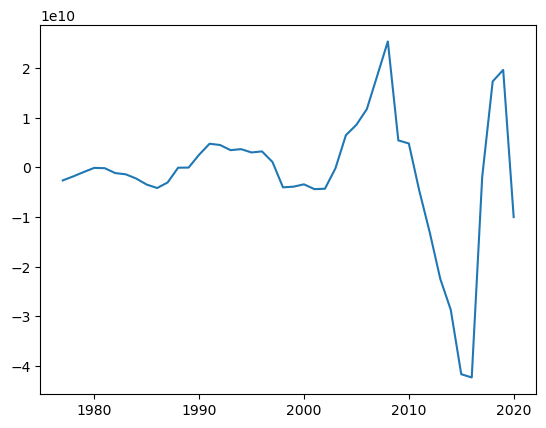

In [25]:
# Time Plot for Deviation from Long-Term Equilibrium
S = (
      vecm_model.beta[0][0] * df.EXP
    + vecm_model.beta[1][0] * df.G
    + vecm_model.beta[2][0] * df.I
)
plt.plot(S)
plt.show()

In [26]:
# ADF Test Result for Deviation from Long-Term Equilibrium
S_adf = ADF(S, trend="n", method="bic")
#print("Augmented Dickey-Fuller Unit Root Test\n", S_adf.regression.summary())
print("\nTest statistics and critical values: \n", S_adf)


Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -1.929
P-value                         0.051
Lags                                8
-------------------------------------

Trend: No Trend
Critical Values: -2.63 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The P-value is 0.051 compared to 0.069 in the original dataset. Though we still can't reject the null hypothesis of unit root in the linear combination, we are very close. Given that this dataset is very murky and that there is a room to solve additional potential issues in the data, this is a considerable improvement.

## **Deployment**

Though this model uses macroeconomic data, it can be deployed to enhance the performance of a financial engineer. Either by using the standalone model, or by integrating it with other models.

The model described in this report can be used for macroeconomic forecasting based on the embedded long term equilibrium and short term movements in the included indicators. This forecasting is vital for investment decisions, particularly in emerging markets and high yield sovereign bonds. It is also helpful in evaluating the risk associated with macroeconomic shocks (e.g., Red Sea shipping crisis). The model can also used for policy analysis, as it can simulate government policies and its effects on other sectors.

Though the model described in this report uses annual data imported using the World Bank API, it can be modified to use more frequent data (e.g., quarterly) if it was available.

The model can also be integrated with other models to formulate a larger forecasting system. This model can provide the macroeconomic forecasting level that can be fed into other more specific models (e.g., sector or market specific).

## **References**

1. Rosca, Elisabeta R. “Stationary and Non-stationary Time Series.” *The USV Annals of Economics and Public Administration*, vol. 10, no. 1, June 2010, http://annals.feaa.usv.ro/index.php/annals/article/viewArticle/262.

2. “Unit Root Tests - Lesson Notes.” *WorldQuant University*, https://learn.wqu.edu/my-path/courses/financial-econometrics/modules/m-6-time-series-modeling-iii-cointegration/tasks/lesson-1-unit-root-tests-lesson-notes.

3. Johansen, Soren. “A Statistical Analysis of Cointegration for I(2) Variables.” *Econometric Theory*, vol. 11, 1995, pp. 25-59, https://www.jstor.org/stable/3532929.

4. Susmel, Rauli. “Lecture Notes on Cointegration.” *University of Houston*, 2006, https://www.bauer.uh.edu/rsusmel/phd/ec2-7.pdf.

5. “Vector Error Correction Model and Johansen Test for Cointegration - Lesson Notes.” *WorldQuant University*, https://learn.wqu.edu/my-path/courses/financial-econometrics/modules/m-6-time-series-modeling-iii-cointegration/tasks/lesson-4-vector-error-correction-model-and-johansen-test-for-cointegration-lesson-notes.

6. Fazzari, Steven M., Pietro E. Ferri, Edward G. Greenberg, and Anna Maria Variato. “Aggregate Demand, Instability, and Growth.” *Review of Keynesian Economics*, vol. 1, no. 1, Spring 2013, pp. 1-21, https://www.elgaronline.com/view/journals/roke/1-1/roke.2013.01.01.xml.

7. Herzog, T. “wbgapi-cookbook.” *GitHub*, https://nbviewer.org/github/tgherzog/wbgapi/blob/master/examples/wbgapi-cookbook.ipynb.

8. Chen, Pu. “Vector Error Correction Models with Stationary and Nonstationary Variables.” *SSRN*, 14 Sep. 2022,  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4218834.